In [1]:
using MKL, LinearAlgebra
using PhysicalUnits
using MoireIVC.LLHF
using MoireIVC.LLED
using CairoMakie
CairoMakie.activate!()

In [2]:
system = LLHF.define_MoTe2system();
k_index = [
     0;  0;;
    +1;  0;;
     0; +1;;
    -1; +1;;
    -1;  0;;
     0; -1;;
    +1; -1;;
]
E_1 = 5.37meV
# Hmf[k,s,s',kD] c†_{k,s,kD} c_{k,s',kD};
function DiracCone(E_1=E_1, k_index=k_index)
    k_num = size(k_index,2)
    Hmf = zeros(ComplexF64, k_num, 2, 2, 2)
    if k_num == 1
        return Hmf
    elseif k_num == 7

        h1diag = 0.0
        h1offd = E_1
        for i in 1:6
            phase = ((i-1)/3-1/6)*pi
            Hmf[1+i,:,:,1] .=[h1diag;  h1offd*cis(phase);;  h1offd*cis(-phase); h1diag] 
            Hmf[1+i,:,:,2] .=[h1diag; -h1offd*cis(phase);; -h1offd*cis(-phase); h1diag] 
        end

        return Hmf
    else
        error("k_num should be 0 or 7")
    end
end
Hmf=DiracCone();

### 1. each Dirac point accompanied with 6 k-points

In [20]:
para1 = LLED_init(k_index[:,[1,2,5]], Hmf[[1,2,5],:,:,:], system, 30, 1);
blocks1, block_k1_1, block_k2_1, bn0_1 = 
LLED_block_bysmallmomentum(LLED_mbslist_twoDiracCone(para1, 5, 5);
    k1range=(-2,2), k2range=(-2,2)
);
blocks1[bn0_1];
int_list1= LLED_interactionlist(para1)

121-element Vector{Tuple{ComplexF64, Vararg{Int64, 4}}}:
 (0.48624966720959856 + 1.8964207029837458e-19im, 5, 2, 2, 5)
 (0.48624966720959856 - 2.1794800420958726e-20im, 11, 8, 8, 11)
 (0.4713172694445404 - 3.6835036391657203e-19im, 8, 2, 2, 8)
 (0.4713172694445404 + 3.6835036391657203e-19im, 11, 5, 5, 11)
 (0.5381170383852383 - 5.839481852022986e-20im, 8, 5, 5, 8)
 (-0.012595916895422929 - 0.0027351286928538427im, 8, 5, 2, 11)
 (0.5381170383852383 + 5.839481852022986e-20im, 11, 2, 2, 11)
 (0.043795974591408736 - 8.211051648242818e-20im, 2, 0, 0, 2)
 (0.043795974591408736 + 8.211051648242818e-20im, 5, 3, 3, 5)
 (0.4854852991479532 + 3.2505470319625483e-19im, 3, 2, 2, 3)
 ⋮
 (-0.014002705135683738 - 6.011620556365646e-6im, 7, 3, 0, 10)
 (0.5397248629752918 - 5.490197417496733e-20im, 10, 0, 0, 10)
 (0.48624966720959856 - 1.454940258242574e-19im, 4, 1, 1, 4)
 (0.48624966720959856 - 2.9255652179923457e-19im, 10, 7, 7, 10)
 (0.47131726944454044 - 3.971495487467036e-19im, 7, 1, 1, 7)
 (0.4713

##### eigenenergies of blocks with momentum close to zero

In [18]:
N_eigen = 8
eigenenergy = Matrix{Float64}(undef, N_eigen, length(blocks1));
for bn in eachindex(blocks1)
    println(bn, "\t", length(blocks1[bn]))
    @time H = LLED_Block_Hamiltonian(blocks1[bn], int_list1, para1)
    @time vals, vecs = LLED_solve(H, N_eigen)
    if length(vals) >= N_eigen
        eigenenergy[:,bn] = real.(vals[1:N_eigen])
    else
        eigenenergy[1:length(vals),bn] = real.(vals)
        eigenenergy[1+length(vals):N_eigen,bn] = NaN
    end
end

1	18
100   0.000550 seconds (1.19 k allocations: 99.786 KiB)
  0.000467 seconds (171 allocations: 43.067 KiB)
2	48
100   0.001159 seconds (3.25 k allocations: 268.720 KiB)
  0.002181 seconds (772 allocations: 235.910 KiB)
3	114
100   0.003036 seconds (8.20 k allocations: 656.584 KiB)
  0.002564 seconds (937 allocations: 532.049 KiB)
4	208
100   0.004383 seconds (16.47 k allocations: 1.431 MiB)
  0.002110 seconds (942 allocations: 669.961 KiB)
5	114
100   0.002218 seconds (8.26 k allocations: 658.506 KiB)
  0.003647 seconds (947 allocations: 537.189 KiB)
6	48
100   0.001210 seconds (3.25 k allocations: 268.063 KiB)
  0.001372 seconds (766 allocations: 236.035 KiB)
7	208
100   0.008951 seconds (16.45 k allocations: 1.432 MiB)
  0.005381 seconds (938 allocations: 669.508 KiB)
8	248
100   0.018322 seconds (19.27 k allocations: 1.641 MiB)
  0.012864 seconds (3.48 k allocations: 2.607 MiB)
9	248
100   0.014304 seconds (19.24 k allocations: 1.641 MiB)
  0.011554 seconds (3.48 k allocations: 2

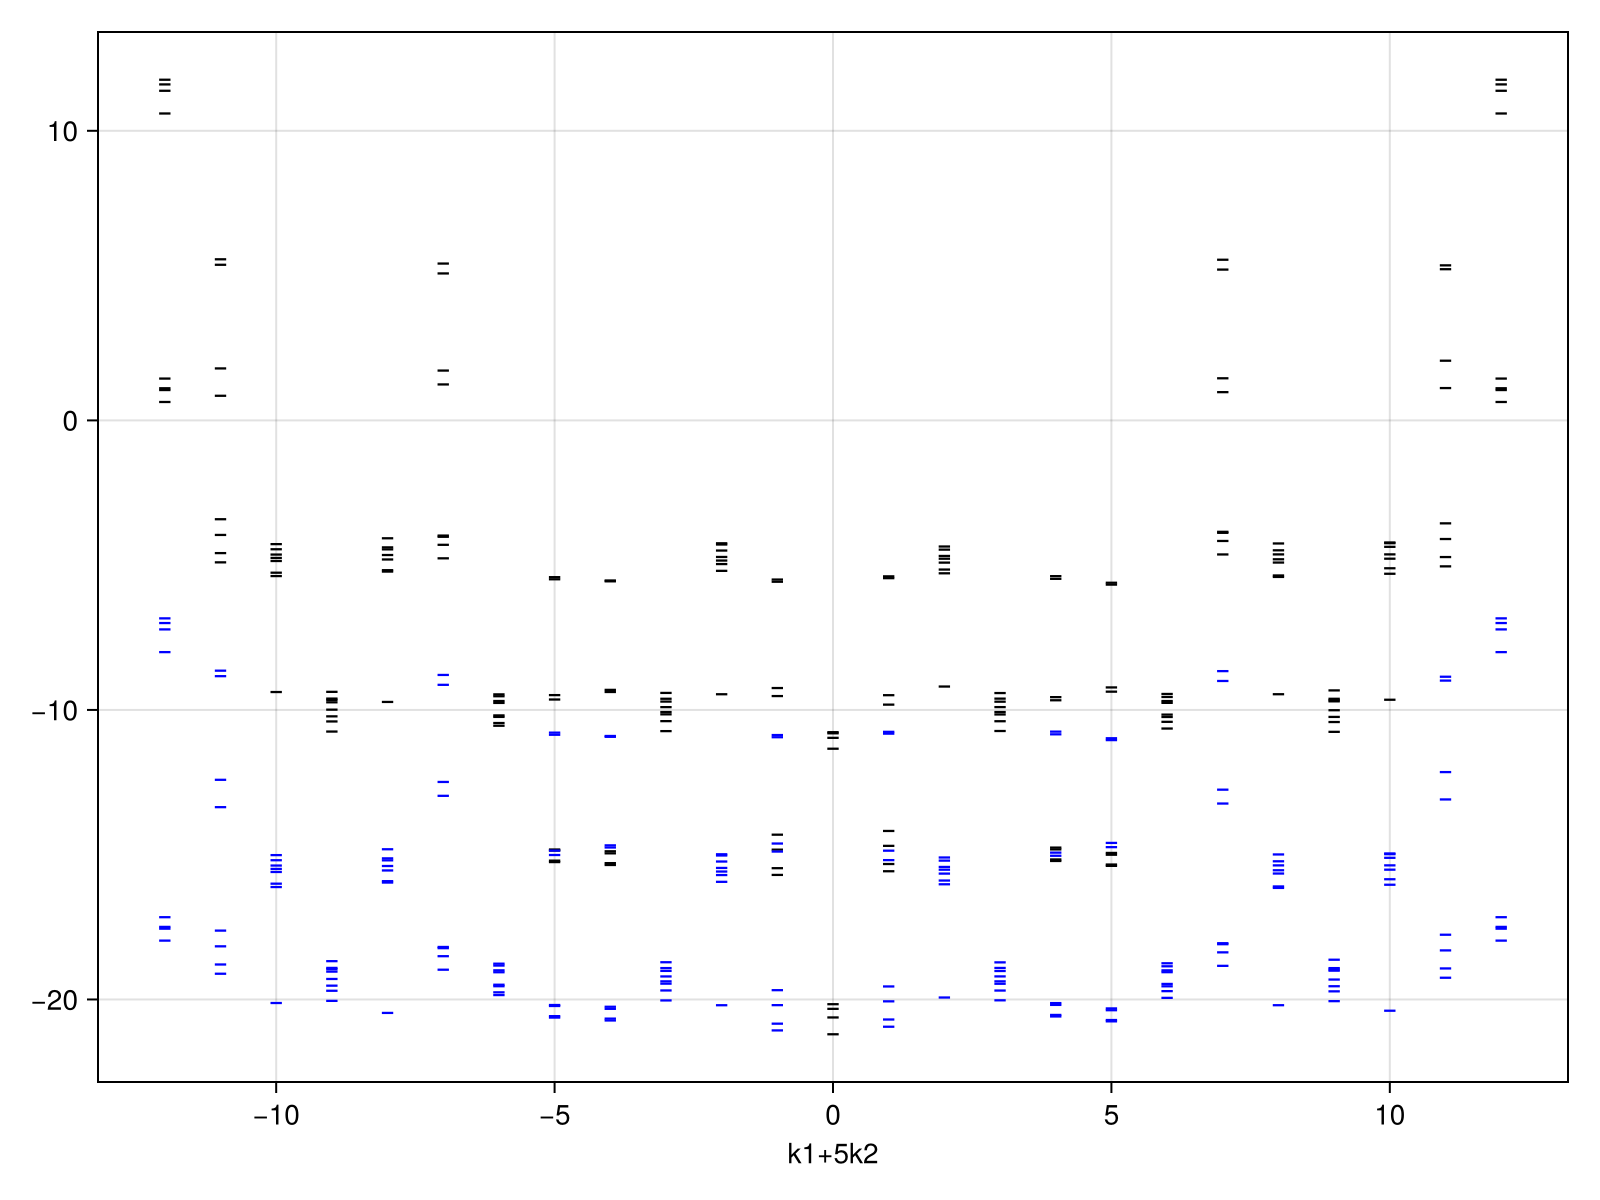

In [19]:
# plot eigenenergies of blocks
eigEs = Figure(size = (800,600));
ax = Axis(eigEs[1,1],
    xlabel = "k1+5k2",
)
for bn in eachindex(blocks1)
    k1 = block_k1_1[bn]; k2 = block_k2_1[bn]
    xticknumber = k1 + 5k2
    energy_shift = E_1 * sqrt(k1^2 + k2^2 + k1*k2)
    for j in 1:N_eigen
        if !isnan(eigenenergy[j, bn])
            scatter!(ax, xticknumber, eigenenergy[j, bn];
                color=:black, marker=:hline
            )
            if xticknumber != 0
                scatter!(ax,xticknumber,eigenenergy[j,bn]-energy_shift;
                    color=:blue, marker=:hline
                )
            end
        end
    end
end
eigEs

In [ ]:
# ground state energy (color) vs. block momentum
lowest_E = Figure(size = (800,600));
ax_le = Axis(lowest_E[1,1])
Emin = Base.vec(eigenenergy[1,:])
block_kx = block_k1_1 .* system.G1[1] + block_k2_1 .* system.G2[1]
block_ky = block_k1_1 .* system.G1[2] + block_k2_1 .* system.G2[2]
sc = scatter!(ax_le, block_kx, block_ky;
    color = Emin, markersize = 20
)
Colorbar(lowest_E[1,2], sc)
lowest_E

##### calculate and analysis the k=0 eigenwavefunctions

In [ ]:
@time H_k0 = LLED_Block_Hamiltonian(blocks1[bn0_1], int_list1, para1)
ishermitian(H_k0)
@time vals_k0, vecs_k0 = LLED_solve(H_k0, 10);
@show vals_k0
dot(vecs_k0[1], vecs_k0[2])

In [ ]:
# one-body reduced density matrix
vec0 = vecs_k0[3]
onebodyRDM = LLED.one_body_reduced_density_matrix(vec0,blocks1[bn0_1])
@show tr(onebodyRDM)/14
@show maximum(abs.(onebodyRDM))
heatmap(abs.(onebodyRDM), colorrange = (0,1))

In [ ]:
# reduced density matices and entanglement entropies
vec0 = vecs_k0[1]

# 1. Dirac point 1
using Combinatorics
iA1 = [0;7];
nA1 = (i_set -> sum(1 .<< i_set; init = 0)).(collect(powerset(iA1)));
RDM_1 = LLED.reduced_density_matrix(vec0, blocks1[bn0_1], nA1, iA1);
@show entropy1 = LLED.entanglement_entropy(RDM_1)
# 2. Dirac point 2
iA2 = [14;21];
nA2 = (i_set -> sum(1 .<< i_set; init = 0)).(collect(powerset(iA2)));
RDM_2 = LLED.reduced_density_matrix(vec0, blocks1[bn0_1], nA2, iA2);
@show entropy2 = LLED.entanglement_entropy(RDM_2)
# 3. two Dirac points
iA3 = [0;7;14;21];
nA3 = (i_set -> sum(1 .<< i_set; init = 0)).(collect(powerset(iA3)));
RDM_3 = LLED.reduced_density_matrix(vec0, blocks1[bn0_1], nA3, iA3);
@show entropy3 = LLED.entanglement_entropy(RDM_3)
# 4. all k-points near Dirac point 1
iA4 = collect(0:13);
nA4 = getfield.(LLED.mbslist_oneDiracCone(para1, 7), :n);
RDM_4 = LLED.reduced_density_matrix(vec0, blocks1[bn0_1], nA4, iA4);
@show entropy4 = LLED.entanglement_entropy(RDM_4)

### 2. only the two Dirac points

In [3]:
para2 = LLED_init(k_index[:,[1]], Hmf[[1],:,:,:], system, 30, 1);
blocks2 = 
LLED_block_bysmallmomentum(LLED_mbslist_twoDiracCone(para2, 1, 1);
    momentum_restriction = false
)[1]
int_list2 = LLED_interactionlist(para2)
@show H2_k0 = LLED_Block_Hamiltonian(blocks2[1], int_list2, para2)
@show vals2_k0, vecs2_k0 = eigen(Matrix(H2_k0))

H2_k0 = LLED_Block_Hamiltonian(blocks2[1], int_list2, para2) = sparse([1, 2, 3, 2, 3, 4], [1, 2, 2, 3, 3, 4], ComplexF64[0.47131726944454044 + 0.0im, 0.5402690172289842 + 0.0im, -0.013909728774944955 + 6.098677750417114e-34im, -0.013909728774944955 - 6.098677750417114e-34im, 0.5402690172289842 + 0.0im, 0.47131726944454044 + 0.0im], 4, 4)
(vals2_k0, vecs2_k0) = eigen(Matrix(H2_k0)) = Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}([0.47131726944454044, 0.47131726944454044, 0.5263592884540393, 0.5541787460039292], ComplexF64[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im -0.7071067811865477 - 3.1002879088190756e-32im -0.7071067811865475 - 3.1002879088190745e-32im; 0.0 + 0.0im 0.0 + 0.0im -0.7071067811865475 - 0.0im 0.7071067811865476 - 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im])


Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 0.47131726944454044
 0.47131726944454044
 0.5263592884540393
 0.5541787460039292
vectors:
4×4 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im        0.0+0.0im                0.0+0.0im
 0.0+0.0im  0.0+0.0im  -0.707107-3.10029e-32im  -0.707107-3.10029e-32im
 0.0+0.0im  0.0+0.0im  -0.707107-0.0im           0.707107-0.0im
 0.0+0.0im  1.0+0.0im        0.0+0.0im                0.0+0.0im

In [6]:
vec0 = vecs2_k0[:,2];
iA = [0;1]; nA = [1;2];
RDM_A = LLED.reduced_density_matrix(vec0, blocks2[1], nA, iA);
entropy = LLED.entanglement_entropy(RDM_A)

0.0